In [1]:
!pip install torch torchvision matplotlib numpy optuna xgboost torchmetrics

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import time
import sys
import os
import itertools
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.optim as optim
import torchvision
from torchvision.models.efficientnet import MBConvConfig, FusedMBConvConfig

import optuna

sys.path.append("/jet/home/azhang19/stat 214/stat-214-lab2-group6/code/modeling")
from preprocessing import to_NCHW, pad_to_384x384, standardize_images
from autoencoder import EfficientNetEncoder, EfficientNetDecoder, AutoencoderConfig
from classification import masked_bce_loss, masked_hinge_loss, l1_reg

device = "cuda" if torch.cuda.is_available() else "cpu"

torch.set_float32_matmul_precision('high')
torch.backends.cudnn.benchmark = True

use_amp = True

#### Loading Data and Autoencoder

In [3]:
# Load and preprocess data
data = np.load("/jet/home/azhang19/stat 214/stat-214-lab2-group6/data/array_data.npz")
unlabeled_images, unlabeled_masks, labeled_images, labeled_masks, labels = data["unlabeled_images"], data["unlabeled_masks"], data["labeled_images"], data["labeled_masks"], data["labels"]

unlabeled_images = pad_to_384x384(to_NCHW(unlabeled_images))
unlabeled_masks = pad_to_384x384(unlabeled_masks)

labeled_images = pad_to_384x384(to_NCHW(labeled_images))
labeled_masks = pad_to_384x384(labeled_masks)
labels = pad_to_384x384(labels)

# Convert to tensors and move to GPU
unlabeled_images = torch.tensor(unlabeled_images, dtype=torch.float32).to(device)  # [161, 8, 384, 384]
unlabeled_masks = torch.tensor(unlabeled_masks, dtype=torch.bool).to(device)    # [161, 384, 384]

labeled_images = torch.tensor(labeled_images, dtype=torch.float32).to(device)      # [3, 8, 384, 384]
labeled_masks = torch.tensor(labeled_masks, dtype=torch.bool).to(device)        # [3, 384, 384]
labels = torch.tensor(labels, dtype=torch.long).to(device)                      # [3, 384, 384]


# Standardize images
unlabeled_images, std_channel, mean_channel = standardize_images(unlabeled_images, unlabeled_masks)
labeled_images, _, _ = standardize_images(labeled_images, labeled_masks, std_channel, mean_channel)

In [5]:
# model with the best baseline classifier performance
best_autoencoder_model_path = "/jet/home/azhang19/stat 214/stat-214-lab2-group6/code/modeling/ckpt/AutoencoderConfig([1, 1, 1], flip=False, rotate=True)/autoencoder_800.pth"

In [6]:
ckpt_path = "/jet/home/azhang19/stat 214/stat-214-lab2-group6/code/modeling/ckpt"
saved_epoch = [100, 200, 400, 800, 1600, 3200, 6400, 12800, 15000, 20000, 25000, 30000, 35000, 40000]

all_features = torch.zeros((2, 2, 2, 2, 2, len(saved_epoch), 3, 64, 384, 384)).to(device)

num_layers_per_block = [1, 2]
augementation = [True, False]
for block1, block2, block3, flip, rotate in itertools.product(*[num_layers_per_block] * 3,*[augementation] * 2):
    config = AutoencoderConfig(
        num_layers_block=[block1, block2, block3],
        augmentation_flip=flip,
        augmentation_rotate=rotate
    )
    encoder_config = [
        FusedMBConvConfig(1, 3, 1, 16, 16, config.num_layers_block[0]),  # 384x384x8 -> 384x384x16
        FusedMBConvConfig(4, 3, 2, 16, 32, config.num_layers_block[1]),  # 384x384x16 -> 192x192x32
        MBConvConfig(4, 3, 2, 32, 64, config.num_layers_block[2]),       # 192x192x32 -> 96x96x64
    ]

    encoder = EfficientNetEncoder(
        inverted_residual_setting=encoder_config,
        dropout=0.1,
        input_channels=8,
        last_channel=64,
    )

    decoder = EfficientNetDecoder()
    autoencoder = nn.Sequential(encoder, decoder).train().to(device)

    folder_path = os.path.join(ckpt_path, str(config))
    
    for i, epoch in enumerate(saved_epoch):
        autoencoder.load_state_dict(torch.load(os.path.join(folder_path, f"autoencoder_{epoch}.pth")))
        autoencoder.eval()
        with torch.inference_mode():
            encoder = autoencoder[0]
            features = encoder(labeled_images)
            features = nn.functional.interpolate(features, size=384, mode="bicubic", antialias=True)
            all_features[block1-1, block2-1, block3-1, int(flip), int(rotate), i] = features

#### Random Forest Algorithm

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

def train_rf_classifier(features, labels, test_size=0.2, n_estimators=100, max_depth=None,
                        min_samples_split=2, min_samples_leaf=1, max_features="sqrt"):
    """
    Train and evaluate a Random Forest classifier on autoencoder features
    
    Args:
        features (torch.Tensor): Tensor of shape [2, channels, H, W]
        labels (torch.Tensor): Ground truth labels tensor of shape [2, H, W]
    """
    #cross-val indices
    train_val_idx = [0, 1]
    
    binary_f1_scores = torch.zeros(len(train_val_idx))
    macro_f1_scores = torch.zeros(len(train_val_idx))
    accuracy_scores = torch.zeros(len(train_val_idx))
    roc_auc_scores = torch.zeros(len(train_val_idx))

    for i in train_val_idx:
        #cross-val split
        train_idx = [j for j in train_val_idx if j != i]
        val_idx = [i]
        train_data = features[train_idx]
        train_labels = labels[train_idx]
        val_data = features[val_idx]
        val_labels = labels[val_idx]

        def process(data, labels):
            #flatten
            flat_data = data.permute(0, 2, 3, 1).contiguous().view(-1, data.size(1)).cpu().numpy()
            flat_labels = labels.view(-1).cpu().numpy()
            
            #remove unlabeled pixels (0), convert -1 to 0
            mask = flat_labels != 0
            return flat_data[mask], np.where(flat_labels[mask] == -1, 0, flat_labels[mask])

        X_train, y_train = process(train_data, train_labels)
        X_val, y_val = process(val_data, val_labels)

        #train rf model
        rf = RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            max_features=max_features,
            class_weight='balanced',
        )
        rf.fit(X_train, y_train)
        
        #validation metrics
        y_pred = rf.predict(X_val)
        binary_f1_scores[i] = f1_score(y_val, y_pred, average='binary')
        macro_f1_scores[i] = f1_score(y_val, y_pred, average='macro')
        accuracy_scores[i] = accuracy_score(y_val, y_pred)
        roc_auc_scores[i] = roc_auc_score(y_val, rf.predict_proba(X_val)[:, 1])

    return {
        'f1_binary': binary_f1_scores.mean().item(),
        'f1_macro': macro_f1_scores.mean().item(),
        'accuracy': accuracy_scores.mean().item(),
        'roc_auc': roc_auc_scores.mean().item(),
        'model': rf
    }


In [8]:
#Get best autoencoder features from previous study (different notebook)
# best_block1 = study.best_params['block1']
# best_block2 = study.best_params['block2']
# best_block3 = study.best_params['block3']
# best_flip = study.best_params['flip']
# best_rotate = study.best_params['rotate']
# best_epoch_idx = study.best_params['epoch']
# with_original = study.best_params['with_original']

best_block1 = 1
best_block2 = 1
best_block3 = 1
best_flip = False
best_rotate = True
best_epoch_idx = 5
with_original = True

In [9]:
rf_orig_features_results = train_rf_classifier(
    features=labeled_images,
    labels=labels,
    test_size=0.2,
    n_estimators=200,
    max_depth=10
)

In [143]:
rf_orig_feature_model = rf_orig_features_results['model']

In [22]:
print("\nRandom Forest Results:")
print(f"- F1 Score: {rf_orig_features_results['f1_binary']:.4f}")
print(f"- Macro F1 Score: {rf_orig_features_results['f1_macro']:.4f}")
print(f"- Accuracy: {rf_orig_features_results['accuracy']:.4f}")
print(f"- ROC AUC: {rf_orig_features_results['roc_auc']:.4f}")


Random Forest Results:
- F1 Score: 0.7986
- Macro F1 Score: 0.8542
- Accuracy: 0.8851
- ROC AUC: 0.9576


#### Feature Importance Analysis

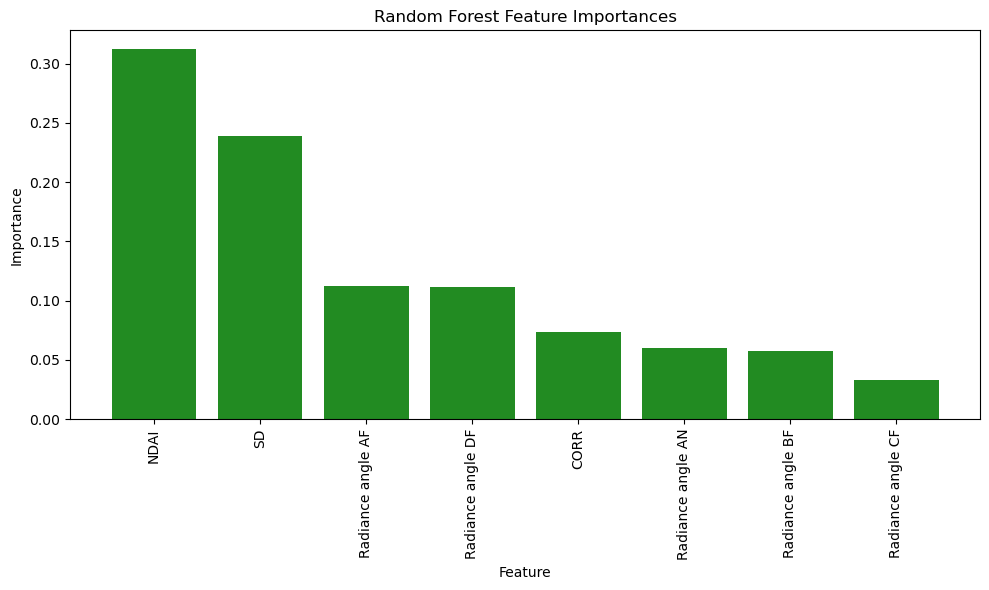

In [23]:
importances = rf_orig_features_results['model'].feature_importances_
feature_names = ['NDAI', 'SD', 'CORR', 'Radiance angle DF', 'Radiance angle CF', 'Radiance angle BF', 'Radiance angle AF', 'Radiance angle AN']

#sorting by importance
sorted_indices = np.argsort(importances)[::-1]
sorted_importances = importances[sorted_indices]
sorted_feature_names = [feature_names[i] for i in sorted_indices]

#plot feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_importances)), sorted_importances, align='center', color = 'forestgreen')
plt.xticks(range(len(sorted_importances)), sorted_feature_names, rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Random Forest Feature Importances')
plt.tight_layout()
plt.savefig('rf_orig_feature_importances.png', dpi=400, bbox_inches='tight')
plt.show()

In [11]:
best_features = all_features[best_block1-1, best_block2-1, best_block3-1, 
                            int(best_flip), int(best_rotate), best_epoch_idx]

rf_autoencoder_only_results = train_rf_classifier(
    features=best_features,
    labels=labels,
    test_size=0.2,
    n_estimators=200,
    max_depth=10
)

In [12]:
print("\nRandom Forest Results:")
print(f"- F1 Score: {rf_autoencoder_only_results['f1_binary']:.4f}")
print(f"- Macro F1 Score: {rf_autoencoder_only_results['f1_macro']:.4f}")
print(f"- Accuracy: {rf_autoencoder_only_results['accuracy']:.4f}")
print(f"- ROC AUC: {rf_autoencoder_only_results['roc_auc']:.4f}")


Random Forest Results:
- F1 Score: 0.6870
- Macro F1 Score: 0.7909
- Accuracy: 0.8542
- ROC AUC: 0.9666


In [13]:
print("\nTraining Random Forest Classifier...")

best_features = all_features[best_block1-1, best_block2-1, best_block3-1, 
                            int(best_flip), int(best_rotate), best_epoch_idx]
# Add original images if needed
if with_original:
    best_features = torch.cat([best_features, labeled_images], dim=1)
# Standardize features
best_features, _, _ = standardize_images(best_features, labeled_masks)


rf_results = train_rf_classifier(
    features=best_features,
    labels=labels,
    test_size=0.2,
    n_estimators=200,
    max_depth=10
)

\nTraining Random Forest Classifier...


In [14]:
print("\nRandom Forest Results:")
print(f"- F1 Score: {rf_results['f1_binary']:.4f}")
print(f"- Macro F1 Score: {rf_results['f1_macro']:.4f}")
print(f"- Accuracy: {rf_results['accuracy']:.4f}")
print(f"- ROC AUC: {rf_results['roc_auc']:.4f}")


Random Forest Results:
- F1 Score: 0.6940
- Macro F1 Score: 0.7953
- Accuracy: 0.8570
- ROC AUC: 0.9670


In [10]:
#Optuna for hyperparameter tuning
def objective_rf(trial):
    """
    Objective function for Optuna hyperparameter optimization
    """
    #suggest hyperparameters
    n_estimators = trial.suggest_int("n_estimators", 50, 500)
    max_depth = trial.suggest_int("max_depth", 5, 50)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None])

    #train rf model
    rf_results = train_rf_classifier(
        features=best_features,
        labels=labels,
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features
    )

    #return metric being optimized
    return rf_results['f1_macro']

In [ ]:
best_features = all_features[best_block1-1, best_block2-1, best_block3-1, 
                            int(best_flip), int(best_rotate), best_epoch_idx]
# Add original images if needed
if with_original:
    best_features = torch.cat([best_features, labeled_images], dim=1)
# Standardize features
best_features, _, _ = standardize_images(best_features, labeled_masks)

#Create Optuna study for finding hyperparamters
study_rf = optuna.create_study(direction="maximize")
study_rf.optimize(objective_rf, n_trials=100, n_jobs=4)

[I 2025-03-20 22:36:22,854] A new study created in memory with name: no-name-5e52f24b-ed12-49e3-a25d-20756ae79b24
[I 2025-03-20 22:40:05,842] Trial 54 finished with value: 0.7912487983703613 and parameters: {'n_estimators': 59, 'max_depth': 6, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 54 with value: 0.7912487983703613.
[I 2025-03-20 22:40:11,762] Trial 77 finished with value: 0.7981632947921753 and parameters: {'n_estimators': 58, 'max_depth': 9, 'min_samples_split': 10, 'min_samples_leaf': 7, 'max_features': 'log2'}. Best is trial 77 with value: 0.7981632947921753.
[I 2025-03-20 22:41:51,774] Trial 24 finished with value: 0.7991640567779541 and parameters: {'n_estimators': 55, 'max_depth': 47, 'min_samples_split': 14, 'min_samples_leaf': 6, 'max_features': 'log2'}. Best is trial 24 with value: 0.7991640567779541.
[I 2025-03-20 22:44:03,988] Trial 94 finished with value: 0.7995977401733398 and parameters: {'n_estimators': 62, 'max_depth': 12,

In [40]:
 #load best parameters from study
try:
    best_params_rf = study_rf.best_params
except NameError:
    best_params_rf = {
        'n_estimators': 113,
        'max_depth': 41,
        'min_samples_split': 6,
        'min_samples_leaf': 8,
        'max_features': 'log2'
    }

In [41]:
#train final model with best hyperparameters
tuned_rf_results = train_rf_classifier(
    features=best_features,
    labels=labels,
    **best_params_rf #unpack hyperparams
)

print(f"Best Hyperparameters: {best_params_rf}")
print(f"Cross-Validated Binary F1: {tuned_rf_results['f1_binary']:.4f}")
print(f"Cross-Validated Macro F1: {tuned_rf_results['f1_macro']:.4f}")
print(f"Cross-Validated Accuracy: {tuned_rf_results['accuracy']:.4f}")
print(f"Validation ROC AUC: {tuned_rf_results['roc_auc']:.4f}")

Best Hyperparameters: {'n_estimators': 113, 'max_depth': 41, 'min_samples_split': 6, 'min_samples_leaf': 8, 'max_features': 'log2'}
Cross-Validated Binary F1: 0.6998
Cross-Validated Macro F1: 0.7985
Cross-Validated Accuracy: 0.8581
Validation ROC AUC: 0.9693


#### Variability Check

In [13]:
best_features = all_features[best_block1-1, best_block2-1, best_block3-1, 
                            int(best_flip), int(best_rotate), best_epoch_idx]
# Add original images if needed
if with_original:
    best_features = torch.cat([best_features, labeled_images], dim=1)
# Standardize features
best_features, _, _ = standardize_images(best_features, labeled_masks)

f1_binary_results = []
f1_macro_results = []
accuracy_results = []
roc_auc_results = []

#10 trials
for i in range(10):
    print(f"Run {i+1}/10")
    final_rf_results = train_rf_classifier(
        features=best_features,
        labels=labels,
        **rf_best_params #unpack best hyperparams
    )

    f1_binary_results.append(final_rf_results['f1_binary'])
    f1_macro_results.append(final_rf_results['f1_macro'])
    accuracy_results.append(final_rf_results['accuracy'])
    roc_auc_results.append(final_rf_results['roc_auc'])

f1_binary_results = np.array(f1_binary_results)
f1_macro_results = np.array(f1_macro_results)
accuracy_results = np.array(accuracy_results)
roc_auc_results = np.array(roc_auc_results)

#calculate mean and standard deviation for each metrics to get intervals
f1_binary_mean, f1_binary_std = f1_binary_results.mean(), f1_binary_results.std()
f1_macro_mean, f1_macro_std = f1_macro_results.mean(), f1_macro_results.std()
accuracy_mean, accuracy_std = accuracy_results.mean(), accuracy_results.std()
roc_auc_mean, roc_auc_std = roc_auc_results.mean(), roc_auc_results.std()

print(f"Mean Cross-Validated Binary F1: {f1_binary_mean:.4f} ± {f1_binary_std:.4f}")
print(f"Mean Cross-Validated Macro F1: {f1_macro_mean:.4f} ± {f1_macro_std:.4f}")
print(f"Mean Cross-Validation Accuracy: {accuracy_mean:.4f} ± {accuracy_std:.4f}")
print(f"Mean Validation ROC AUC: {roc_auc_mean:.4f} ± {roc_auc_std:.4f}")

Run 1/10
Run 2/10
Run 3/10
Run 4/10
Run 5/10
Run 6/10
Run 7/10
Run 8/10
Run 9/10
Run 10/10
Mean Cross-Validated Binary F1: 0.6968 ± 0.0037
Mean Cross-Validated Macro F1: 0.7965 ± 0.0024
Mean Cross-Validation Accuracy: 0.7954 ± 0.0017
Mean Validation ROC AUC: 0.9562 ± 0.0021


In [28]:
def generate_cross_val_pred_interval(features, labels, model_train_func, best_params):
    f1_binary_results = []
    f1_macro_results = []
    accuracy_results = []
    roc_auc_results = []
    
    for i in range(10):
        print(f"Run {i+1}/10")
        final_rf_results = model_train_func(
            features=features,
            labels=labels,
            **best_params  #unpack best hyperparameters
        )
        
        f1_binary_results.append(final_rf_results['f1_binary'])
        f1_macro_results.append(final_rf_results['f1_macro'])
        accuracy_results.append(final_rf_results['accuracy'])
        roc_auc_results.append(final_rf_results['roc_auc'])
    
    f1_binary_results = np.array(f1_binary_results)
    f1_macro_results = np.array(f1_macro_results)
    accuracy_results = np.array(accuracy_results)
    roc_auc_results = np.array(roc_auc_results)
    
    #calculate mean and standard deviation for each metrics to get intervals
    f1_binary_mean, f1_binary_std = f1_binary_results.mean(), f1_binary_results.std()
    f1_macro_mean, f1_macro_std = f1_macro_results.mean(), f1_macro_results.std()
    accuracy_mean, accuracy_std = accuracy_results.mean(), accuracy_results.std()
    roc_auc_mean, roc_auc_std = roc_auc_results.mean(), roc_auc_results.std()
    
    print(f"Mean Cross-Validated Binary F1: {f1_binary_mean:.4f} ± {f1_binary_std:.4f}")
    print(f"Mean Cross-Validated Macro F1: {f1_macro_mean:.4f} ± {f1_macro_std:.4f}")
    print(f"Mean Cross-Validation Accuracy: {accuracy_mean:.4f} ± {accuracy_std:.4f}")
    print(f"Mean Validation ROC AUC: {roc_auc_mean:.4f} ± {roc_auc_std:.4f}")

In [29]:
best_features = all_features[best_block1-1, best_block2-1, best_block3-1, 
                            int(best_flip), int(best_rotate), best_epoch_idx]
# Add original images if needed
if with_original:
    best_features = torch.cat([best_features, labeled_images], dim=1)
# Standardize features
best_features, _, _ = standardize_images(best_features, labeled_masks)

#XGBoost combined
generate_cross_val_pred_interval(best_features, labels, train_xgb_classifier, best_params_xgb)

Run 1/10
Run 2/10
Run 3/10
Run 4/10
Run 5/10
Run 6/10
Run 7/10
Run 8/10
Run 9/10
Run 10/10
Mean Cross-Validated Binary F1: 0.7103 ± 0.0000
Mean Cross-Validated Macro F1: 0.8064 ± 0.0000
Mean Cross-Validation Accuracy: 0.8635 ± 0.0000
Mean Validation ROC AUC: 0.9547 ± 0.0000


In [31]:
#XGBoost orig
generate_cross_val_pred_interval(labeled_images, labels, train_xgb_classifier, best_params_xgb)

Run 1/10
Run 2/10
Run 3/10
Run 4/10
Run 5/10
Run 6/10
Run 7/10
Run 8/10
Run 9/10
Run 10/10
Mean Cross-Validated Binary F1: 0.7922 ± 0.0000
Mean Cross-Validated Macro F1: 0.8539 ± 0.0000
Mean Cross-Validation Accuracy: 0.8880 ± 0.0000
Mean Validation ROC AUC: 0.9675 ± 0.0000


In [32]:
#random forest orig
generate_cross_val_pred_interval(labeled_images, labels, train_rf_classifier, best_params_rf)

Run 1/10
Run 2/10
Run 3/10
Run 4/10
Run 5/10
Run 6/10
Run 7/10
Run 8/10
Run 9/10
Run 10/10
Mean Cross-Validated Binary F1: 0.7964 ± 0.0019
Mean Cross-Validated Macro F1: 0.8532 ± 0.0015
Mean Cross-Validation Accuracy: 0.8849 ± 0.0014
Mean Validation ROC AUC: 0.9667 ± 0.0009



Feature Importance Analysis:


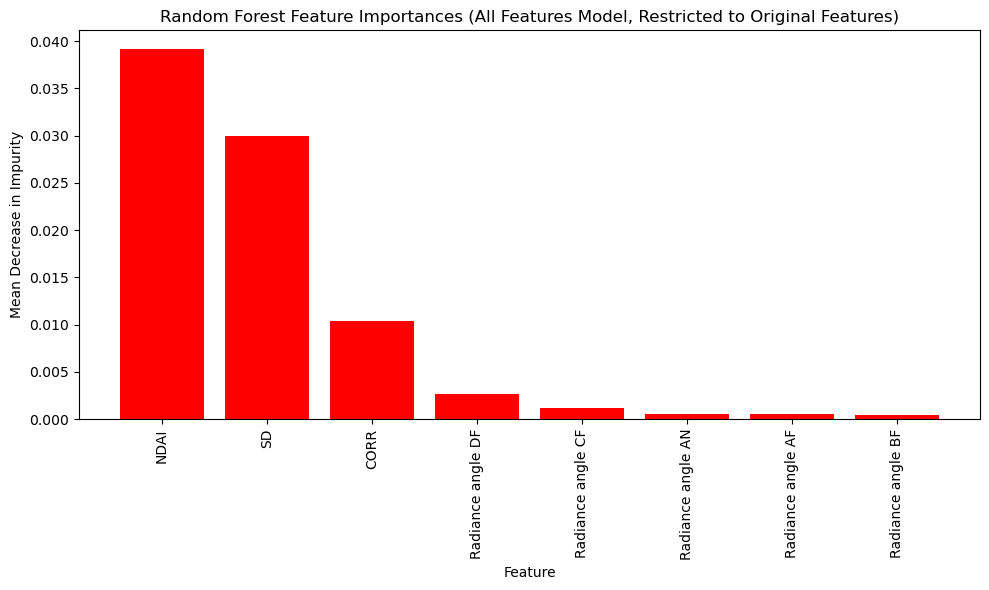

In [24]:
# Feature Importance Analysis
print("\nFeature Importance Analysis:")

#restrict to orig features
feature_names = ['NDAI', 'SD', 'CORR', 'Radiance angle DF', 'Radiance angle CF', 'Radiance angle BF', 'Radiance angle AF', 'Radiance angle AN']
importances = tuned_rf_results['model'].feature_importances_[-8:]

#sort by importance
sorted_indices = np.argsort(importances)[::-1]
sorted_importances = importances[sorted_indices]
sorted_feature_names = [feature_names[i] for i in sorted_indices]

#plot
plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_importances)), sorted_importances, align='center', color='r')
plt.xticks(range(len(sorted_importances)), sorted_feature_names, rotation=90)
plt.xlabel("Feature")
plt.ylabel("Mean Decrease in Impurity")
plt.title("Random Forest Feature Importances (All Features Model, Restricted to Original Features)")
plt.tight_layout()
plt.savefig('rf_restricted_feature_importance.png', dpi=400, bbox_inches='tight')
plt.show()


Feature Importance Analysis:


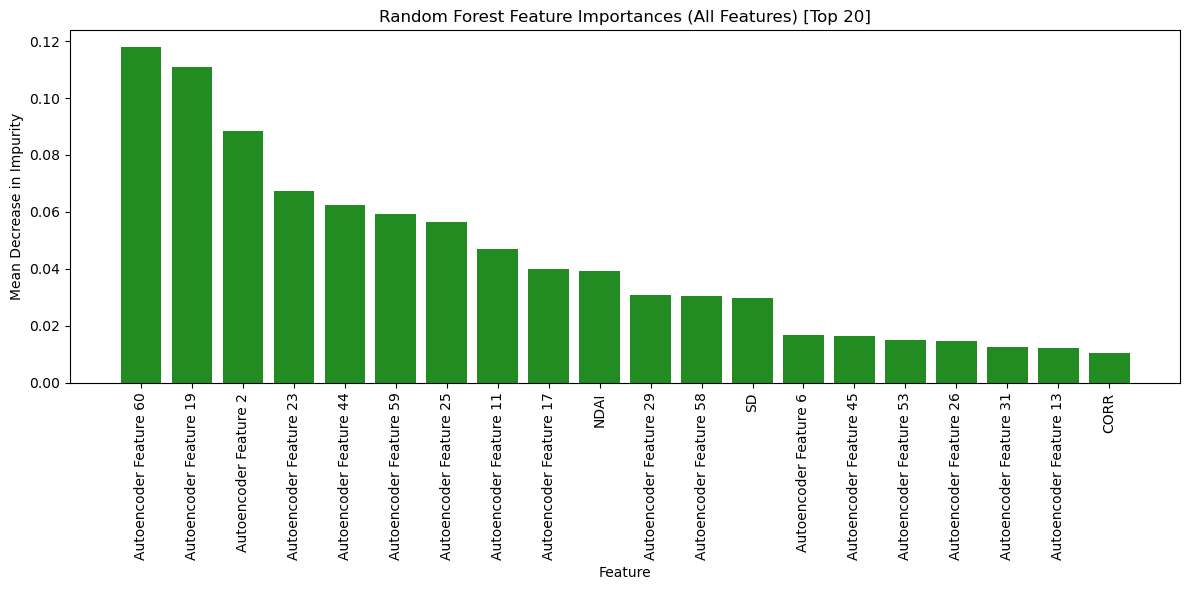

In [25]:
# Feature Importance Analysis
print("\nFeature Importance Analysis:")

#importances for all features
importances = tuned_rf_results['model'].feature_importances_
feature_names = ['NDAI', 'SD', 'CORR', 'Radiance angle DF', 'Radiance angle CF', 'Radiance angle BF', 'Radiance angle AF', 'Radiance angle AN']

#placeholder names for autoencoder features (all features except last 8)
num_autoencoder_features = len(importances) - len(feature_names)
autoencoder_feature_names = [f'Autoencoder Feature {i+1}' for i in range(num_autoencoder_features)]

all_feature_names = autoencoder_feature_names + feature_names

#sort features by importance
sorted_indices = np.argsort(importances)[::-1]
sorted_importances = importances[sorted_indices]
sorted_feature_names = [all_feature_names[i] for i in sorted_indices]

#plot and restrict to top 20
plt.figure(figsize=(12, 6))
plt.bar(range(len(sorted_importances[:20])), sorted_importances[:20], align='center', color='forestgreen')
plt.xticks(range(len(sorted_importances[:20])), sorted_feature_names[:20], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Mean Decrease in Impurity")
plt.title("Random Forest Feature Importances (All Features) [Top 20]")
plt.tight_layout()
plt.savefig('rf_full_feature_importances.png', dpi=400, bbox_inches='tight')
plt.show()

In [20]:
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split

def train_xgb_classifier(features, labels, test_size=0.2, n_estimators=100, max_depth=3, learning_rate=0.1, reg_lambda=1):
    """
    Train and evaluate an XGBoost classifier on autoencoder features
    
    Args:
        features (torch.Tensor): Tensor of shape [2, channels, H, W]
        labels (torch.Tensor): Ground truth labels tensor of shape [2, H, W]
    """
    #cross-val indices
    train_val_idx = [0, 1]
    
    binary_f1_scores = torch.zeros(len(train_val_idx))
    macro_f1_scores = torch.zeros(len(train_val_idx))
    accuracy_scores = torch.zeros(len(train_val_idx))
    roc_auc_scores = torch.zeros(len(train_val_idx))

    for i in train_val_idx:
        #cross-val split
        train_idx = [j for j in train_val_idx if j != i]
        val_idx = [i]

        train_data = features[train_idx]
        train_labels = labels[train_idx]
        val_data = features[val_idx]
        val_labels = labels[val_idx]

        def process(data, labels):
            #flatten
            flat_data = data.permute(0, 2, 3, 1).contiguous().view(-1, data.size(1)).cpu().numpy()
            flat_labels = labels.view(-1).cpu().numpy()
            
            #remove unlabeled pixels (0) and convert -1 to 0
            mask = flat_labels != 0
            return flat_data[mask], np.where(flat_labels[mask] == -1, 0, flat_labels[mask])

        X_train, y_train = process(train_data, train_labels)
        X_val, y_val = process(val_data, val_labels)

        class_weights = len(y_train) / (2 * np.bincount(y_train))
        
        #train XGBoost
        xgb = XGBClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=learning_rate,
            reg_lambda=reg_lambda,
            scale_pos_weight=class_weights[1]/class_weights[0],
            eval_metric='logloss',
        )
        xgb.fit(X_train, y_train)
        
        y_pred = xgb.predict(X_val)
        binary_f1_scores[i] = f1_score(y_val, y_pred, average='binary')
        macro_f1_scores[i] = f1_score(y_val, y_pred, average='macro')
        accuracy_scores[i] = accuracy_score(y_val, y_pred)
        roc_auc_scores[i] = roc_auc_score(y_val, xgb.predict_proba(X_val)[:, 1])
        

    return {
        'f1_binary': binary_f1_scores.mean().item(),
        'f1_macro': macro_f1_scores.mean().item(),
        'accuracy': accuracy_scores.mean().item(),
        'roc_auc': roc_auc_scores.mean().item(),
        'model': xgb
    }

In [9]:
best_features = all_features[best_block1-1, best_block2-1, best_block3-1, int(best_flip), int(best_rotate), best_epoch_idx]
if with_original:
    best_features = torch.cat([best_features, labeled_images], dim=1)
best_features, _, _ = standardize_images(best_features, labeled_masks)

In [118]:
print("\nTraining XGBoost Classifier...")
xgb_results = train_xgb_classifier(
    features=best_features,
    labels=labels,
    test_size=0.2,
    n_estimators=200,
    max_depth=10,
    learning_rate=0.01
)

print("\nXGBoost Results:")
print(f"- Binary F1 Score: {xgb_results['f1_binary']:.4f}")
print(f"- Macro F1 Score: {xgb_results['f1_macro']:.4f}")
print(f"- Accuracy: {xgb_results['accuracy']:.4f}")
print(f"- ROC AUC: {xgb_results['roc_auc']:.4f}")


Training XGBoost Classifier...

XGBoost Results:
- Binary F1 Score: 0.6894
- Macro F1 Score: 0.7819
- Accuracy: 0.8378
- ROC AUC: 0.8719


In [119]:
#Optuna for hyperparameter tuning
def objective_xgb(trial):
    """
    Objective function for Optuna hyperparameter optimization
    """
    #hyperparameters to tune
    n_estimators = trial.suggest_int("n_estimators", 50, 500)
    max_depth = trial.suggest_int("max_depth", 3, 15)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.3, log=True)
    reg_lambda = trial.suggest_float("reg_lambda", 0, 10)

    #train xgboost model
    xgb_results = train_xgb_classifier(
        features=best_features,
        labels=labels,
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        reg_lambda=reg_lambda
    )

    #return metric being optimized
    return xgb_results['f1_macro']

In [120]:
study_xgb = optuna.create_study(direction="maximize")
study_xgb.optimize(objective_xgb, n_trials=50, n_jobs=4)

[I 2025-03-20 20:29:57,077] A new study created in memory with name: no-name-f5750f07-4440-48e4-a2dd-2c551b44053b
[I 2025-03-20 20:30:01,154] Trial 1 finished with value: 0.7984652519226074 and parameters: {'n_estimators': 138, 'max_depth': 3, 'learning_rate': 0.21470973716135014, 'reg_lambda': 3.8251457070519432}. Best is trial 1 with value: 0.7984652519226074.
[I 2025-03-20 20:30:05,433] Trial 2 finished with value: 0.7952836751937866 and parameters: {'n_estimators': 78, 'max_depth': 15, 'learning_rate': 0.08605341991714825, 'reg_lambda': 8.44904710534954}. Best is trial 1 with value: 0.7984652519226074.
[I 2025-03-20 20:30:10,757] Trial 0 finished with value: 0.7947826385498047 and parameters: {'n_estimators': 387, 'max_depth': 14, 'learning_rate': 0.21700801383297147, 'reg_lambda': 1.986280722685878}. Best is trial 1 with value: 0.7984652519226074.
[I 2025-03-20 20:30:13,204] Trial 3 finished with value: 0.7890982627868652 and parameters: {'n_estimators': 167, 'max_depth': 12, 'lea

In [25]:
try:
    best_params_xgb = study_xgb.best_params
except NameError:
    best_params_xgb = {
    'n_estimators': 429,
    'max_depth': 4,
    'learning_rate': 0.09681310852458384,
    'reg_lambda': 4.689414776012059
}

In [11]:
#train final xgboost model
tuned_xgb_results = train_xgb_classifier(
    features=best_features,
    labels=labels,
    **best_params_xgb  #unpack best hyperparameters
)

print(f"Best Hyperparameters: {best_params_xgb}")
print(f"Cross-Validated Binary F1: {tuned_xgb_results['f1_binary']:.4f}")
print(f"Cross-Validated Macro F1: {tuned_xgb_results['f1_macro']:.4f}")
print(f"Cross-Validated Accuracy: {tuned_xgb_results['accuracy']:.4f}")
print(f"Validation ROC AUC: {tuned_xgb_results['roc_auc']:.4f}")

Best Hyperparameters: {'n_estimators': 429, 'max_depth': 4, 'learning_rate': 0.09681310852458384, 'reg_lambda': 4.689414776012059}
Cross-Validated Binary F1: 0.7103
Cross-Validated Macro F1: 0.8064
Cross-Validated Accuracy: 0.8635
Validation ROC AUC: 0.9547



Generating ROC Curves...


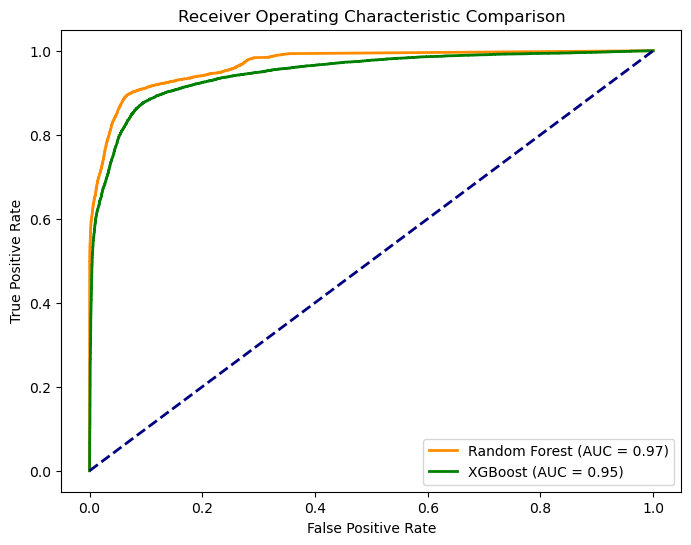

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc_curves(rf_model, xgb_model, features, labels):
    features_flat = features.permute(0, 2, 3, 1).contiguous()
    features_flat = features_flat.view(-1, features.size(1)).cpu().numpy()
    labels_flat = labels.view(-1).cpu().numpy()
    
    #filter unlabeled pixels
    mask = labels_flat != 0
    X = features_flat[mask]
    y = labels_flat[mask]
    
    _, X_val, _, y_val = train_test_split(X, y, test_size=0.2, 
                                        stratify=y, random_state=42)
    
    rf_proba = rf_model.predict_proba(X_val)[:, 1]
    xgb_proba = xgb_model.predict_proba(X_val)[:, 1]
    
    #calculate ROC curves
    fpr_rf, tpr_rf, _ = roc_curve(y_val, rf_proba)
    roc_auc_rf = auc(fpr_rf, tpr_rf)
    
    fpr_xgb, tpr_xgb, _ = roc_curve(y_val, xgb_proba)
    roc_auc_xgb = auc(fpr_xgb, tpr_xgb)
    
    #plot
    plt.figure(figsize=(8, 6))
    plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2,
             label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
    plt.plot(fpr_xgb, tpr_xgb, color='green', lw=2,
             label=f'XGBoost (AUC = {roc_auc_xgb:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Comparison')
    plt.legend(loc="lower right")
    plt.show()


print("\nGenerating ROC Curves...")
plot_roc_curves(tuned_rf_results['model'], tuned_xgb_results['model'], best_features, labels)

## Test Set Prediction

In [16]:
def evaluate_on_test_set(model, features, labels, print_results=False, plot=False, plot_title="", test_image_idx=2):
    """
    Evaluate a trained model on the test set (image 2).
    
    Args:
        model: Trained model (Random Forest or XGBoost)
        features (torch.Tensor): Tensor of shape [num_images, channels, H, W]
        labels (torch.Tensor): Ground truth labels tensor of shape [num_images, H, W]
        test_image_idx (int): Index of the test image (default: 2)
    """
    #get test data (image 2)
    test_features = features[test_image_idx].unsqueeze(0)  # Add batch dimension
    test_labels = labels[test_image_idx]

    #flatten
    test_features_flat = test_features.permute(0, 2, 3, 1).contiguous().view(-1, test_features.size(1)).cpu().numpy()
    test_labels_flat = test_labels.view(-1).cpu().numpy()

    #remove unlabeled pixels (0) and convert -1 to 0
    mask = test_labels_flat != 0
    X_test = test_features_flat[mask]
    y_test = np.where(test_labels_flat[mask] == -1, 0, test_labels_flat[mask])

    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    metrics = {
        'f1_binary': f1_score(y_test, y_pred, average='binary'),
        'f1_macro': f1_score(y_test, y_pred, average='macro'),
        'accuracy': accuracy_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_proba)
    }

    if print_results:
        print(f"Test Set Metrics (Image {test_image_idx}):")
        print(f"- Binary F1: {metrics['f1_binary']:.4f}")
        print(f"- Macro F1: {metrics['f1_macro']:.4f}")
        print(f"- Accuracy: {metrics['accuracy']:.4f}")
        print(f"- ROC AUC: {metrics['roc_auc']:.4f}")

    if plot:
        import matplotlib.pyplot as plt
        from matplotlib.colors import ListedColormap, BoundaryNorm
        
        #reshape to image
        pred_map = np.full_like(test_labels_flat, 0) 
        pred_map[mask] = np.where(y_pred == 0, -1, 1) # map predictions: 0 → -1 (non-cloud), 1 → 1 (cloud)
        pred_map = pred_map.reshape(test_labels.shape)
        
        # Create discrete color mappings
        cmap = ListedColormap(['blue', 'gray', 'red'])  # -1=blue (non-cloud), 0=gray (unlabeled), 1=red (cloud)
        boundaries = [-1.5, -0.5, 0.5, 1.5]  # Boundaries between categories
        norm = BoundaryNorm(boundaries, ncolors=3)
    
        # Plot
        plt.figure(figsize=(12, 6))
        
        # Ground Truth Plot
        plt.subplot(1, 2, 1)
        gt_plot = plt.imshow(test_labels.cpu().numpy(), cmap=cmap, norm=norm)
        plt.suptitle(plot_title)
        plt.title("Ground Truth")
        plt.xlabel("Width (pixels)")  # Add x-axis label
        plt.ylabel("Height (pixels)")  # Add y-axis label
        cbar_gt = plt.colorbar(gt_plot, ticks=[-1, 0, 1], orientation="horizontal")
        cbar_gt.ax.set_xticklabels(['Non-Cloud', 'Unlabeled', 'Cloud'])  # Proper labels
        
        # Prediction Plot
        plt.subplot(1, 2, 2)
        pred_plot = plt.imshow(pred_map, cmap=cmap, norm=norm)
        plt.title("Predictions")
        plt.xlabel("Width (pixels)")  # Add x-axis label
        plt.ylabel("Height (pixels)")  # Add y-axis label
        cbar_pred = plt.colorbar(pred_plot, ticks=[-1, 0, 1], orientation="horizontal")
        cbar_pred.ax.set_xticklabels(['Non-Cloud', 'Unlabeled', 'Cloud'])  # Proper labels
        
        plt.tight_layout()
        plt.savefig('pred_plot.png', dpi=400, bbox_inches='tight')
        plt.show()

        return metrics, pred_map, test_labels

    else:
        return metrics

Test Set Metrics (Image 2):
- Binary F1: 0.5623
- Macro F1: 0.6960
- Accuracy: 0.7548
- ROC AUC: 0.8989


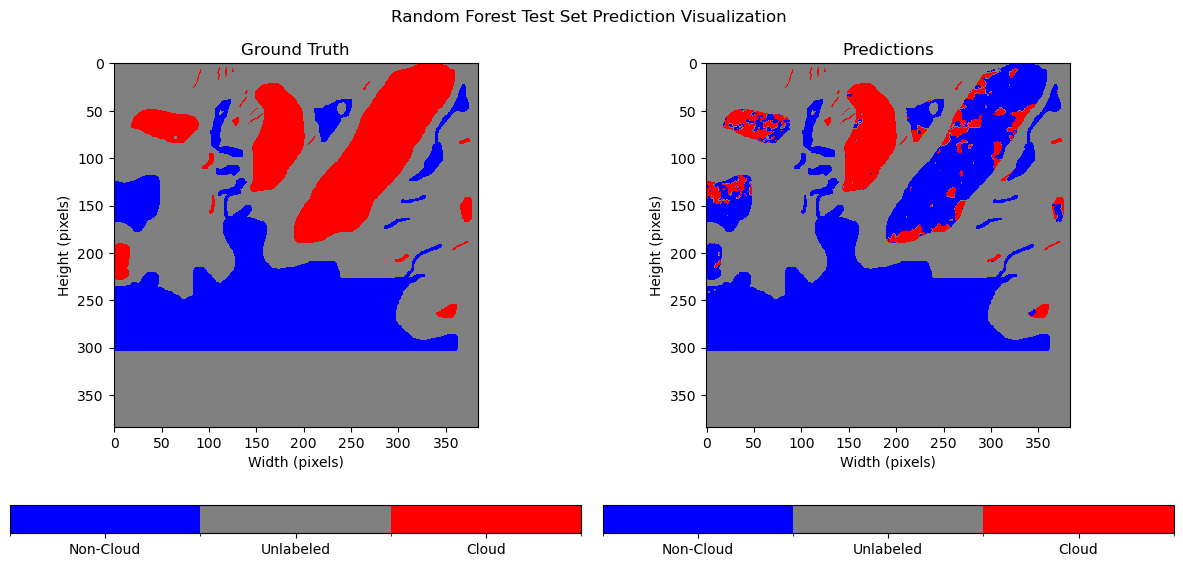

In [42]:
rf_model = tuned_rf_results['model']
rf_test_metrics, pred_map, test_labels = evaluate_on_test_set(rf_model, best_features, labels, print_results=True, plot=True, plot_title="Random Forest Test Set Prediction Visualization", test_image_idx=2)

## Post-Hoc EDA: Error Analysis

In [28]:
def create_error_map(predicted, ground_truth):
    """
    Creates an error map highlighting misclassified pixels.

    Args:
        predicted: 2D array of predicted labels.
        ground_truth: 2D array of ground truth labels.

    Returns:
        error_map: 2D array representing the error map.
    """
    error_map = np.zeros_like(predicted)
    for i in range(predicted.shape[0]):
        for j in range(predicted.shape[1]):
            if ground_truth[i, j] != 0 and predicted[i, j] != ground_truth[i, j]:
                error_map[i, j] = 1  #misclassifications
    return error_map

In [30]:
error_map = create_error_map(pred_map, test_labels)
error_map

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [39]:
from scipy.signal import correlate2d

def spatial_error_correlation(error_map):
    """
    Calculates the spatial autocorrelation of errors.

    Args:
        error_map: 2D array representing the error map.
    """
    autocorr = correlate2d(error_map, error_map, mode='same')
    plt.imshow(autocorr, cmap='viridis')
    plt.title("Spatial Autocorrelation of Errors")
    plt.colorbar()
    plt.savefig('spatial_error_correlation.png', dpi=400, bbox_inches='tight')
    plt.show()

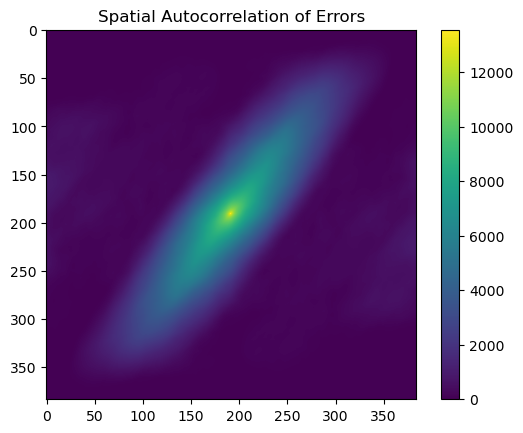

In [40]:
spatial_error_correlation(error_map)

This method of autocorrelation measures how similar the error map is to a shifted version of itself. High values in the center of this plot indicate that errors are strongly correlated with themselves. This means that errors appear in groups/clusters, which aligns with intuition from glancing at the prediction plot. This is contrast to if the high values were away from the center, which would indicate correlation of errors with errors at a distance.

In [45]:
orig_feature_set = features[:, -8:, :, :]
orig_feature_set.shape

torch.Size([3, 8, 384, 384])

In [46]:
def compare_misclassified_vs_correct_feature_patterns(pred_map, test_labels, orig_feature_set, feature_names, test_image_idx=2):
    """
    Compares feature patterns between misclassified and correctly classified regions.

    Args:
        pred_map (np.ndarray): Predicted label map (2D array).
        test_labels (torch.Tensor): Ground truth label map (2D array).
        orig_feature_set (torch.Tensor): Original features tensor [num_images, channels, H, W].
        feature_names (list): List of feature names corresponding to orig_feature_set channels.
        test_image_idx (int): Index of the test image (default: 2).
    """

    #get test image features
    test_features = orig_feature_set[test_image_idx]  # Shape: [channels, H, W]
    
    test_labels = test_labels.cpu().numpy()

    misclassified_mask = (pred_map != test_labels) & (test_labels != 0)
    correct_mask = (pred_map == test_labels) & (test_labels != 0)

    #distribution for misclassified and correctly classified pixels
    for feature_idx in range(test_features.shape[0]):
        feature_data = test_features[feature_idx].cpu().numpy()  # Shape: [H, W]

        #Extract feature values
        misclassified_feature_values = feature_data[misclassified_mask]
        correct_feature_values = feature_data[correct_mask]

        if misclassified_feature_values.size > 0 and correct_feature_values.size > 0:
            # Plot histograms for comparison
            plt.figure(figsize=(10, 5))
            plt.hist(misclassified_feature_values, bins=20, alpha=0.7, label="Misclassified", color='red')
            plt.hist(correct_feature_values, bins=20, alpha=0.5, label="Correct", color='lightblue')
            plt.title(f"{feature_names[feature_idx]} Values: Misclassified vs. Correct")
            plt.xlabel("Feature Value")
            plt.ylabel("Frequency")
            plt.legend()
            plt.show()

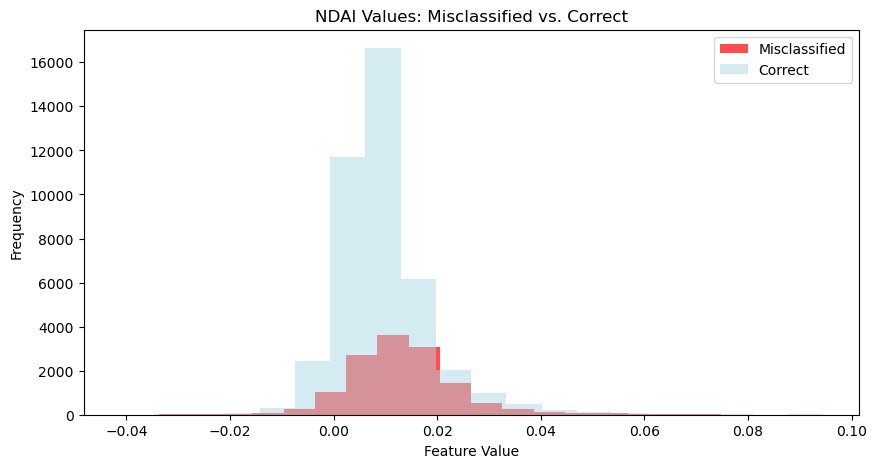

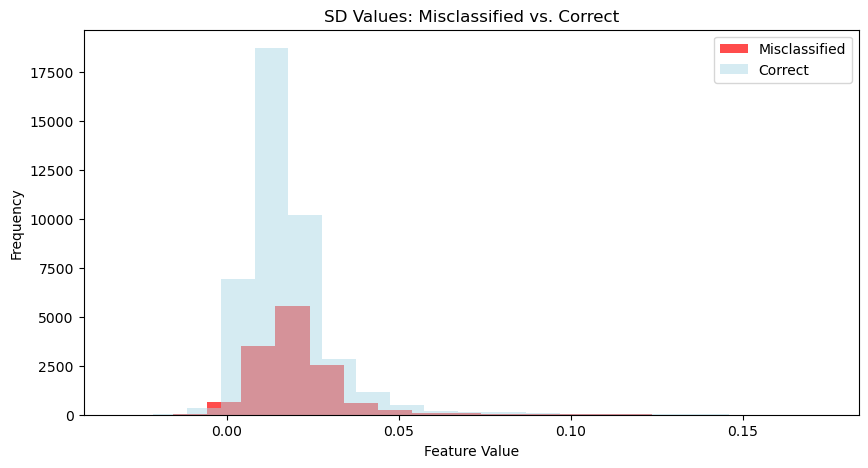

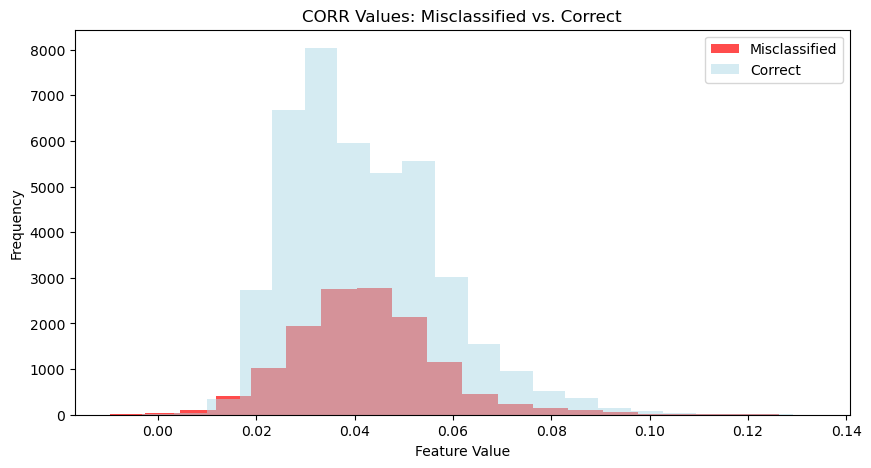

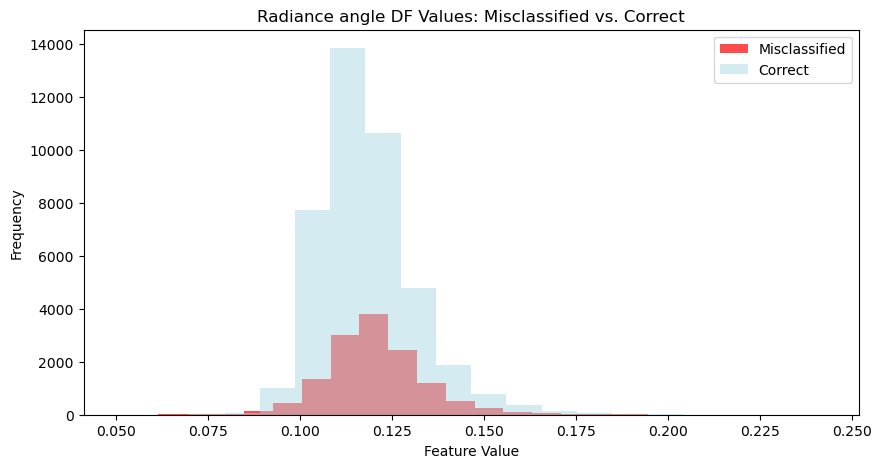

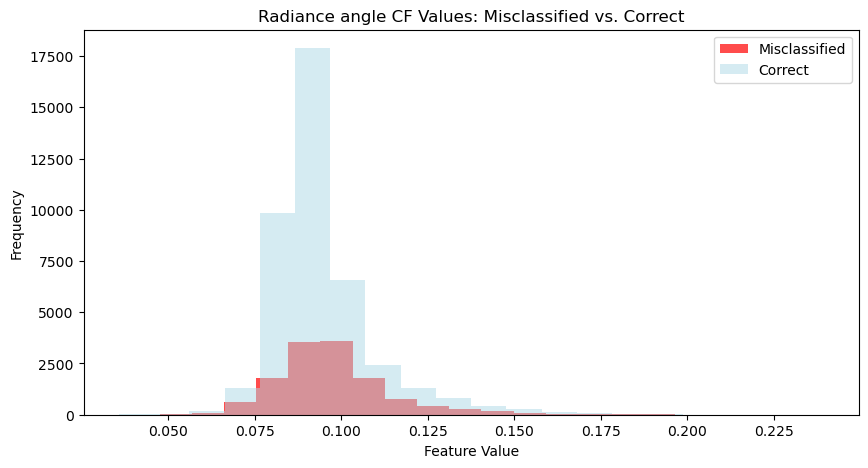

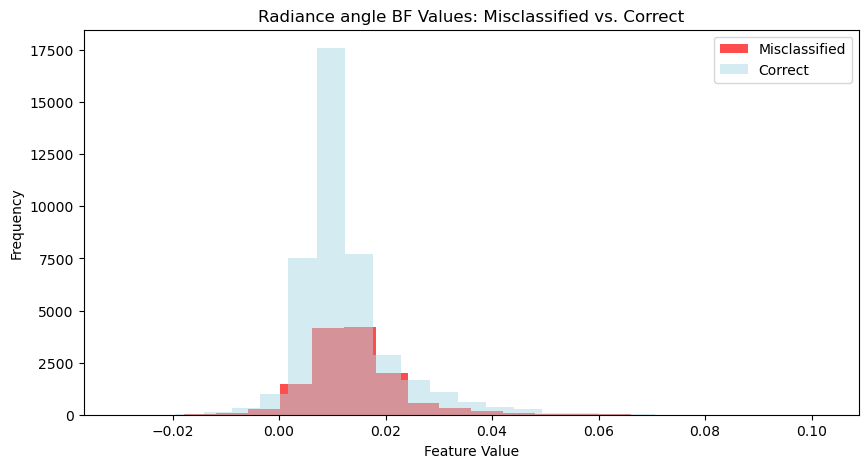

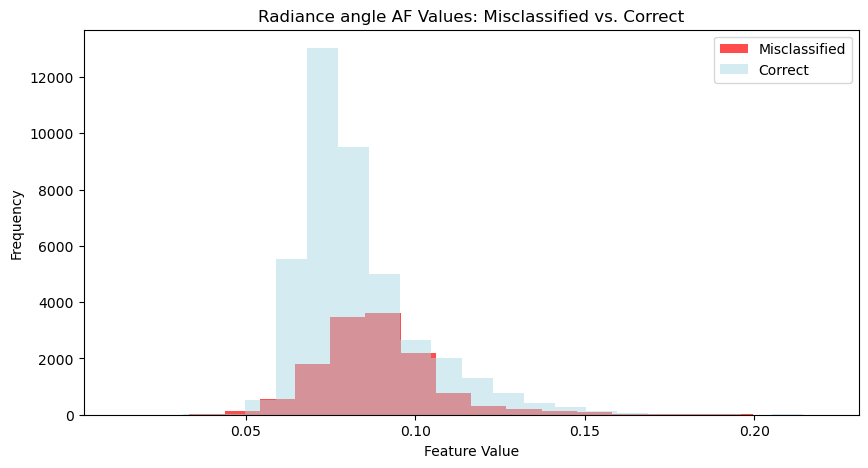

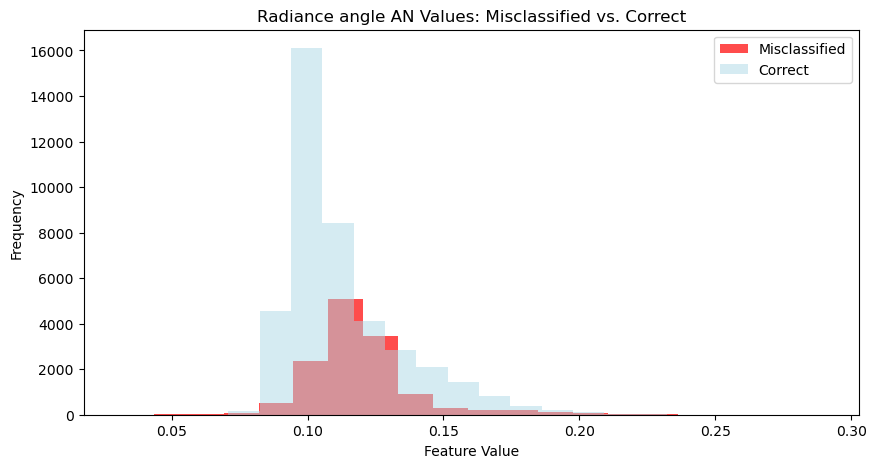

In [48]:
feature_names = ['NDAI', 'SD', 'CORR', 'Radiance angle DF', 'Radiance angle CF', 'Radiance angle BF', 'Radiance angle AF', 'Radiance angle AN']
compare_misclassified_vs_correct_feature_patterns(pred_map, test_labels, orig_feature_set, feature_names)

#### Stability Analysis

In [127]:
from scipy.ndimage import gaussian_filter
import numpy as np

def stability_analysis_predictions_feature_perturbation_gaussian_filter(
    model, features, labels, num_perturbations=10, sigma=1.0, noise_scale=0.1, test_image_idx=2
):
    """
    Performs stability analysis with Gaussian filter perturbation + random noise.
    
    Args:
        noise_scale (float): Scale of random noise added after Gaussian filtering.
    """
    #Get test set (image 2)
    test_features = features[test_image_idx].unsqueeze(0)
    test_labels = labels[test_image_idx].clone()

    #Flatten
    test_features_flat = test_features.permute(0, 2, 3, 1).contiguous().view(-1, test_features.size(1)).cpu().numpy()
    test_labels_flat = test_labels.view(-1).cpu().numpy()
    H, W = test_features.shape[2], test_features.shape[3]

    all_predictions = []

    for _ in range(num_perturbations):
        perturbed_features = np.zeros_like(test_features_flat)
        
        #apply Gaussian filter and random noise to each
        for channel in range(test_features.size(1)):
            channel_data = test_features_flat[:, channel].reshape(H, W)
            smoothed = gaussian_filter(channel_data, sigma=sigma)
            noise = np.random.normal(loc=0, scale=noise_scale, size=(H, W))
            perturbed_channel = smoothed + noise
            
            perturbed_features[:, channel] = perturbed_channel.flatten()

        #Remove unlabeled pixels (0)
        valid_mask = test_labels_flat != 0
        X_test = perturbed_features[valid_mask]

        y_pred = model.predict(X_test)

        pred_map = np.full_like(test_labels_flat, 0)
        pred_map[valid_mask] = np.where(y_pred == 0, -1, 1)
        all_predictions.append(pred_map.reshape(test_labels.shape))

    #Calculate disagreement
    disagreement_map = np.zeros(test_labels.shape)
    for i in range(test_labels.shape[0]):
        for j in range(test_labels.shape[1]):
            pixel_preds = [pred[i, j] for pred in all_predictions]
            disagreement_map[i, j] = len(set(pixel_preds)) - 1  #0 = agreement, 1 = disagreement

    #Visualize disagreement
    plt.imshow(disagreement_map, vmin=0, vmax=1)
    plt.title(f"Disagreement Map - Feature Gaussian Filter")
    plt.colorbar(ticks=[0, 1])
    plt.savefig('feature_gaussian_filter_disagreement_map.png', dpi=400, bbox_inches='tight')
    plt.show()

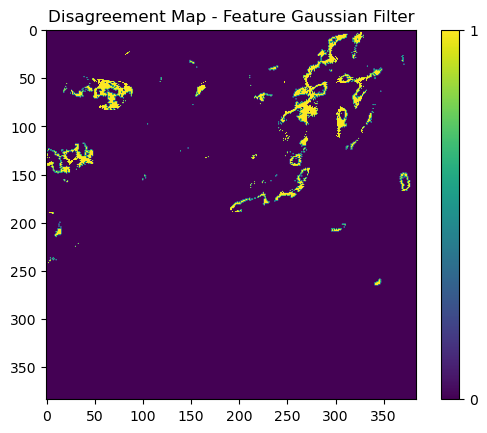

In [128]:
stability_analysis_predictions_feature_perturbation_gaussian_filter(
    rf_model, best_features, labels, sigma=2.0, noise_scale=0.2, num_perturbations=10
)

In [146]:
from matplotlib.colors import ListedColormap, BoundaryNorm

def post_processing_perturbation(rf_model, best_features, labels, sigma=1.0, test_image_idx=2):
    """
    Applies a Gaussian filter to the predicted labels as a post-processing perturbation.
    Preserves unlabeled points (0) in the ground truth.

    Args:
        rf_model: Trained Random Forest model.
        best_features (torch.Tensor): Input features of shape [num_images, channels, H, W].
        labels (torch.Tensor): Ground truth labels of shape [num_images, H, W].
        sigma (float): Standard deviation for the Gaussian filter.
        test_image_idx (int): Index of the test image to evaluate (default: 2).
    """
    #Get test data (image 2)
    test_features = best_features[test_image_idx].unsqueeze(0)
    test_labels = labels[test_image_idx]

    #flatten
    test_features_flat = test_features.permute(0, 2, 3, 1).contiguous().view(-1, test_features.size(1)).cpu().numpy()
    test_labels_flat = test_labels.view(-1).cpu().numpy()

    mask = test_labels_flat != 0
    X_test = test_features_flat[mask]
    y_test = np.where(test_labels_flat[mask] == -1, 0, test_labels_flat[mask])

    y_pred = rf_model.predict(X_test)
    y_proba = rf_model.predict_proba(X_test)[:, 1]

    pred_map = np.zeros_like(test_labels_flat)
    pred_map[mask] = np.where(y_pred == 0, -1, 1)  #Map predictions: 0 → -1 (non-cloud), 1 → 1 (cloud)
    pred_map = pred_map.reshape(test_labels.shape)

    #apply gaussian smoothing to predictions
    pred_map_smoothed = gaussian_filter(pred_map, sigma=sigma)

    pred_map_smoothed = np.where(pred_map_smoothed > 0, 1, -1)

    #preserve unlabeled points (0) from ground truth
    pred_map_smoothed[test_labels.cpu().numpy() == 0] = 0

    # Calculate metrics on smoothed predictions (only for labeled pixels)
    y_pred_smoothed = pred_map_smoothed.reshape(-1)[mask]
    y_test_masked = y_test  # Already masked
    

    # Create discrete colormap for blue, gray, red
    cmap = ListedColormap(['blue', 'gray', 'red'])  # -1=blue (non-cloud), 0=gray (unlabeled), 1=red (cloud)
    boundaries = [-1.5, -0.5, 0.5, 1.5]  # Boundaries between categories
    norm = BoundaryNorm(boundaries, cmap.N)

    # Visualize results
    plt.figure(figsize=(12, 6))

    # Original Predictions Plot
    plt.subplot(1, 2, 1)
    plt.imshow(pred_map, cmap=cmap, norm=norm)
    plt.title("Original Predictions")
    orig_plt = plt.colorbar(ticks=[-1, 0, 1], orientation="horizontal")
    orig_plt.ax.set_xticklabels(['Non-Cloud', 'Unlabeled', 'Cloud'])

    # Smoothed Predictions Plot
    plt.subplot(1, 2, 2)
    plt.imshow(pred_map_smoothed, cmap=cmap, norm=norm)
    plt.title(f"Smoothed Predictions (σ={sigma})")
    smoothed_plt = plt.colorbar(ticks=[-1, 0, 1], orientation="horizontal")
    smoothed_plt.ax.set_xticklabels(['Non-Cloud', 'Unlabeled', 'Cloud'])
    
    plt.tight_layout()
    plt.savefig('post_processing_perturbation.png', dpi=400)
    plt.show()

    return metrics, pred_map_smoothed

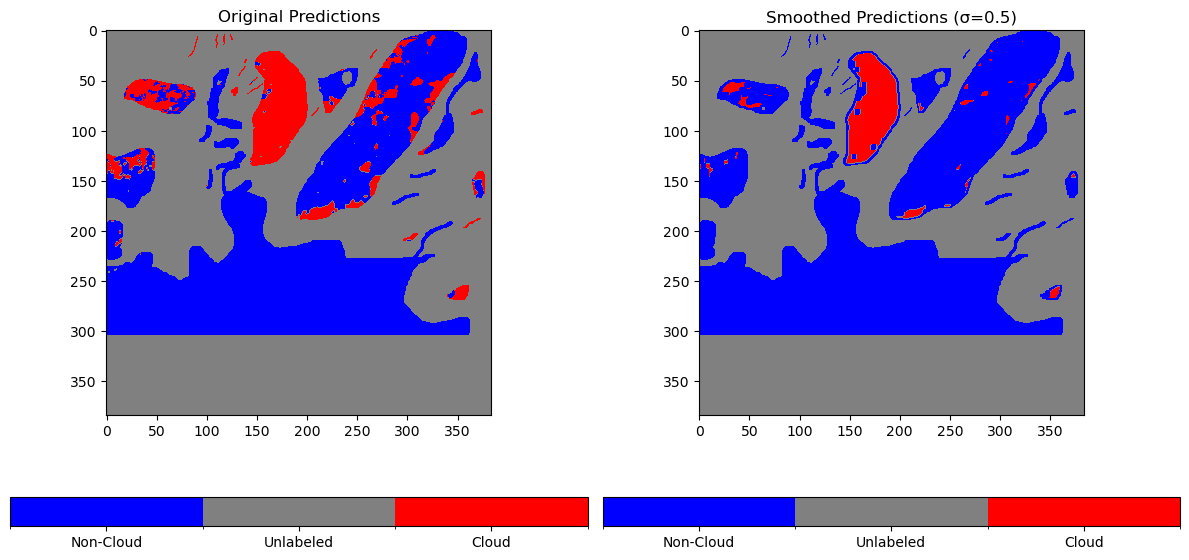

In [147]:
metrics, smoothed_predictions = post_processing_perturbation(
    rf_model, best_features, labels, sigma=0.50, test_image_idx=2
)

Test Set Metrics (Image 2):
- Binary F1: 0.5803
- Macro F1: 0.7064
- Accuracy: 0.7605
- ROC AUC: 0.8844


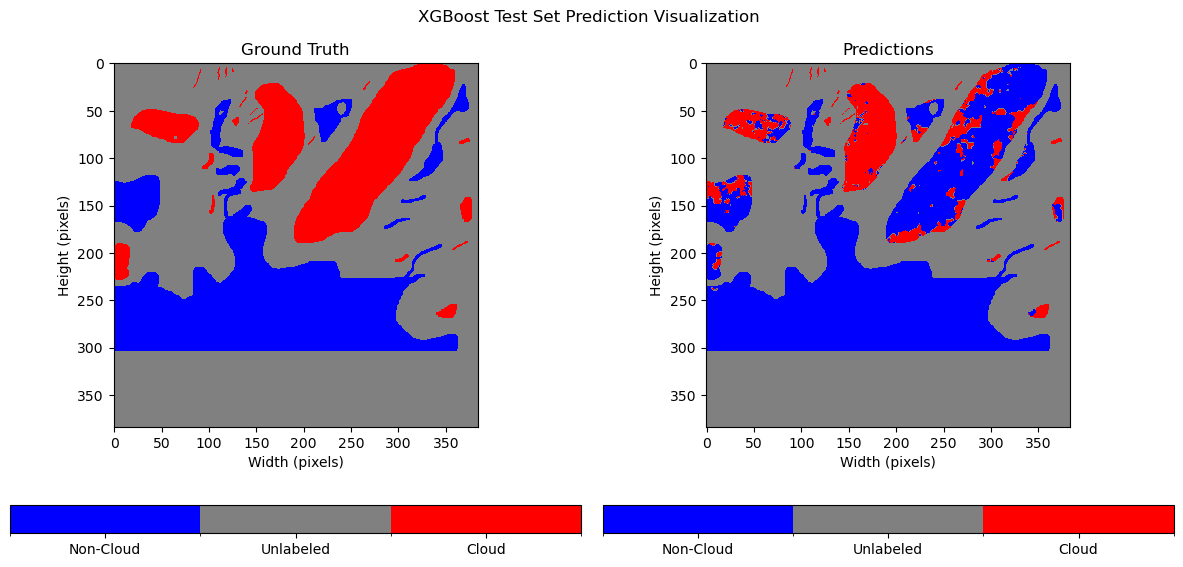

In [73]:
# Assuming xgb_results contains the trained XGBoost model
xgb_model = tuned_xgb_results['model']
xgb_test_metrics = evaluate_on_test_set(xgb_model, best_features, labels, print_results=True, plot=True, plot_title="XGBoost Test Set Prediction Visualization", test_image_idx=2)

#### Further Testing (Variability Check)

In [17]:
def generate_test_pred_interval(features, labels, model_train_func, best_params):
    f1_binary_results = []
    f1_macro_results = []
    accuracy_results = []
    roc_auc_results = []
    
    for i in range(10):
        print(f"Run {i+1}/10")
        curr_model = model_train_func(
            features=features,
            labels=labels,
            **best_params  #Unpack best hyperparameters
        )['model']
    
        test_metrics = evaluate_on_test_set(curr_model, features, labels)
        
        f1_binary_results.append(test_metrics['f1_binary'])
        f1_macro_results.append(test_metrics['f1_macro'])
        accuracy_results.append(test_metrics['accuracy'])
        roc_auc_results.append(test_metrics['roc_auc'])
    
    f1_binary_results = np.array(f1_binary_results)
    f1_macro_results = np.array(f1_macro_results)
    accuracy_results = np.array(accuracy_results)
    roc_auc_results = np.array(roc_auc_results)
    
    f1_binary_mean, f1_binary_std = f1_binary_results.mean(), f1_binary_results.std()
    f1_macro_mean, f1_macro_std = f1_macro_results.mean(), f1_macro_results.std()
    accuracy_mean, accuracy_std = accuracy_results.mean(), accuracy_results.std()
    roc_auc_mean, roc_auc_std = roc_auc_results.mean(), roc_auc_results.std()
    
    print(f"Mean Binary F1: {f1_binary_mean:.4f} ± {f1_binary_std:.4f}")
    print(f"Mean Macro F1: {f1_macro_mean:.4f} ± {f1_macro_std:.4f}")
    print(f"Mean Accuracy: {accuracy_mean:.4f} ± {accuracy_std:.4f}")
    print(f"Mean ROC AUC: {roc_auc_mean:.4f} ± {roc_auc_std:.4f}")

    trial_arrays = {
        'f1_binary': f1_binary_results,
        'f1_macro': f1_macro_results,
        'accuracy': accuracy_results,
        'roc_auc': roc_auc_results
    }
    
    return trial_arrays


In [34]:
trial_arrays = generate_test_pred_interval(best_features, labels, train_rf_classifier, best_params_rf)

Run 1/10
Run 2/10
Run 3/10
Run 4/10
Run 5/10
Run 6/10
Run 7/10
Run 8/10
Run 9/10
Run 10/10
Mean Binary F1: 0.5636 ± 0.0038
Mean Macro F1: 0.6969 ± 0.0022
Mean Accuracy: 0.7556 ± 0.0013
Mean ROC AUC: 0.8888 ± 0.0142


In [23]:
xgb_trial_arrays = generate_test_pred_interval(best_features, labels, train_xgb_classifier, best_params_xgb)

Run 1/10
Run 2/10
Run 3/10
Run 4/10
Run 5/10
Run 6/10
Run 7/10
Run 8/10
Run 9/10
Run 10/10
Mean Binary F1: 0.5818 ± 0.0000
Mean Macro F1: 0.7073 ± 0.0000
Mean Accuracy: 0.7611 ± 0.0000
Mean ROC AUC: 0.8877 ± 0.0000


In [18]:
rf_orig_trial_arrays = generate_test_pred_interval(labeled_images, labels, train_rf_classifier, best_params_rf)

Run 1/10
Run 2/10
Run 3/10
Run 4/10
Run 5/10
Run 6/10
Run 7/10
Run 8/10
Run 9/10
Run 10/10
Mean Binary F1: 0.6962 ± 0.0067
Mean Macro F1: 0.7711 ± 0.0049
Mean Accuracy: 0.7957 ± 0.0045
Mean ROC AUC: 0.7515 ± 0.0077


In [33]:
xgb_orig_feature_array = generate_test_pred_interval(labeled_images, labels, train_xgb_classifier, best_params_xgb)

Run 1/10
Run 2/10
Run 3/10
Run 4/10
Run 5/10
Run 6/10
Run 7/10
Run 8/10
Run 9/10
Run 10/10
Mean Binary F1: 0.6205 ± 0.0000
Mean Macro F1: 0.7198 ± 0.0000
Mean Accuracy: 0.7549 ± 0.0000
Mean ROC AUC: 0.7706 ± 0.0000


In [ ]:
def generate_pred_interval(features, labels, model_train_func, best_params):

    best_features = all_features[best_block1-1, best_block2-1, best_block3-1, 
                                int(best_flip), int(best_rotate), best_epoch_idx]
    # Add original images if needed
    if with_original:
        best_features = torch.cat([best_features, labeled_images], dim=1)
    # Standardize features
    best_features, _, _ = standardize_images(best_features, labeled_masks)
    
    f1_binary_results = []
    f1_macro_results = []
    accuracy_results = []
    roc_auc_results = []
    
    for i in range(10):
        print(f"Run {i+1}/10")
        curr_rf_model = train_rf_classifier(
            features=best_features,
            labels=labels,
            **rf_best_params  #unpack best hyperparameters
        )['model']
    
        _test_metrics = evaluate_on_test_set(xgb_model, best_features, labels,)
        
        f1_binary_results.append(final_rf_results['f1_binary'])
        f1_macro_results.append(final_rf_results['f1_macro'])
        accuracy_results.append(final_rf_results['accuracy'])
        roc_auc_results.append(final_rf_results['roc_auc'])
    
    f1_binary_results = np.array(f1_binary_results)
    f1_macro_results = np.array(f1_macro_results)
    accuracy_results = np.array(accuracy_results)
    roc_auc_results = np.array(roc_auc_results)
    
    f1_binary_mean, f1_binary_std = f1_binary_results.mean(), f1_binary_results.std()
    f1_macro_mean, f1_macro_std = f1_macro_results.mean(), f1_macro_results.std()
    accuracy_mean, accuracy_std = accuracy_results.mean(), accuracy_results.std()
    roc_auc_mean, roc_auc_std = roc_auc_results.mean(), roc_auc_results.std()
    
    print(f"Mean Cross-Validated Binary F1: {f1_binary_mean:.4f} ± {f1_binary_std:.4f}")
    print(f"Mean Cross-Validated Macro F1: {f1_macro_mean:.4f} ± {f1_macro_std:.4f}")
    print(f"Mean Cross-Validation Accuracy: {accuracy_mean:.4f} ± {accuracy_std:.4f}")
    print(f"Mean Validation ROC AUC: {roc_auc_mean:.4f} ± {roc_auc_std:.4f}")